<a href="https://colab.research.google.com/github/nmningmei/Get_Sleep_data/blob/main/Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nmningmei/Get_Sleep_data.git

Cloning into 'Get_Sleep_data'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 11), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [4]:
!pip install mne

     |████████████████████████████████| 7.4 MB 4.0 MB/s 


In [33]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

import mne
import requests 

from tqdm import tqdm
from glob import glob
from matplotlib  import pyplot as plt
from collections import Counter
from sklearn     import metrics
sns.set_style('white')
sns.set_context('poster')

In [7]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in tqdm(r.iter_content(chunk_size=chunk_size),
                          desc = f'downloading {save_path.split("/")[-1]} ...'):
            fd.write(chunk)

In [9]:
 # download the data if not
dataframe_dir   = 'Get_Sleep_data/data'
df              = pd.read_csv(os.path.join(dataframe_dir,'available_subjects.csv'))
EEG_dir         = 'Get_Sleep_data/EEG'
annotation_dir  = 'Get_Sleep_data/annotations'
for f in [EEG_dir,annotation_dir]:
    if not os.path.exists(f):
        os.mkdir(f)

sub,day = 29,1
row     = df[np.logical_and(
            df['sub'] == sub,
            df['day'] == day)]

url_eeg         = row['link'].values[0]
url_vmrk        = row['link'].values[1]
url_vhdr        = row['link'].values[2]
url_annotation  = row['annotation_file_link'].values[0]

if len(os.listdir(EEG_dir)) < 1:
    for url in [url_eeg,url_vmrk,url_vhdr]:
        download_url(url,
                        os.path.join(EEG_dir,url.split('/')[-1],)
                        )
download_url(url_annotation,
                os.path.join(annotation_dir,
                            f'suj{sub}_day{day}_annotations.txt'))


downloading suj29_day1_annotations.txt ...: 44it [00:00, 6115.16it/s]


In [11]:
# load the data
raw = mne.io.read_raw_brainvision(
        glob(os.path.join(EEG_dir,'*.vhdr'))[0],
        preload = True)
# set the EOG channels
channel_types = {'LOc':'eog','ROc':'eog','Aux1':'misc'}
raw.set_channel_types(channel_types)

raw_ref ,_  = mne.set_eeg_reference(raw,
                                    ref_channels     = 'average',
                                    projection       = True,)
raw_ref.apply_proj() # it might tell you it already has been re-referenced, but do it anyway

# read standard montage - montage is important for visualization
montage = mne.channels.make_standard_montage('standard_1020',);#montage.plot()
raw.set_montage(montage)
# print some information about the data
print(raw.info)


Extracting parameters from Get_Sleep_data/EEG/suj29_l5nap_day1.vhdr...
Setting channel info structure...
Reading 0 ... 1804949  =      0.000 ...  1804.949 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, CP5, CP1, Pz, P3, P7, ...
 chs: 61 EEG, 2 EOG, 1 misc
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2016-06-29 12:26:54 UTC
 nchan: 64
 projs: Average EEG reference: on
 sfreq: 1000.0 Hz
>


Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


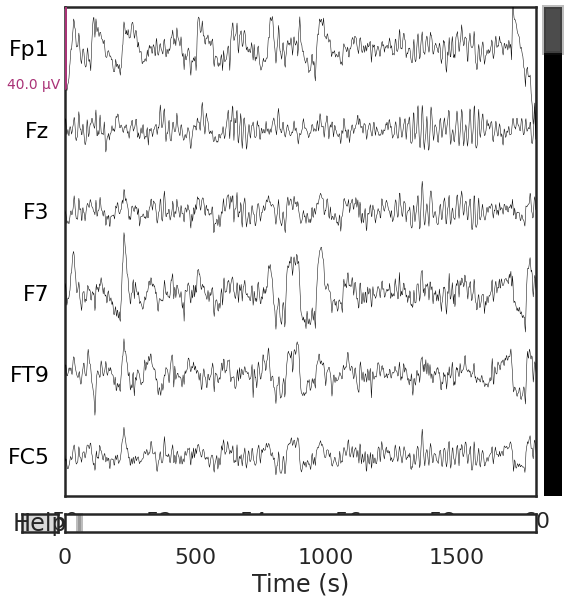

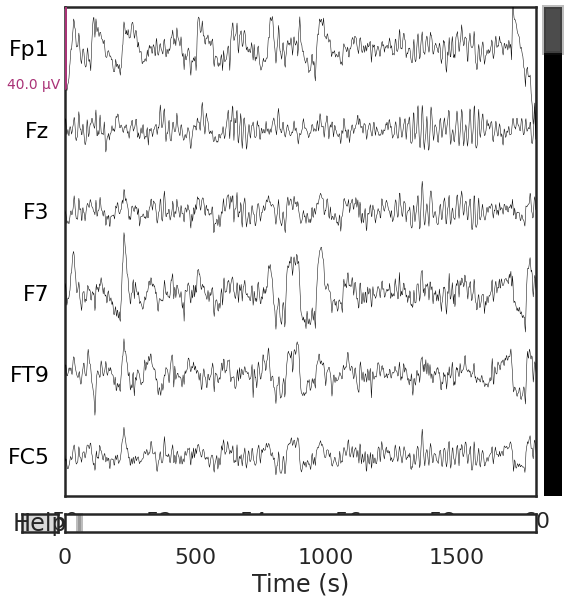

In [12]:
# plot a small chunk of the data
raw.plot(duration = 10,
            start = 50,
            n_channels = 6,
            scalings = dict(eeg=20e-6, eog=150e-6,),
            highpass = 1.,
            lowpass = 30.,
            )


In [13]:
# plot the spindles
events = pd.read_csv(os.path.join(annotation_dir,
                                    f'suj{sub}_day{day}_annotations.txt'))
spindle_events = events[events['Annotation'] == 'spindle']
event_array = np.vstack([spindle_events['Onset'].values,
                            [0] * spindle_events.shape[0],
                            [1] * spindle_events.shape[0]]).T.astype(int)



In [14]:
# filter the raw data
raw.filter(1,30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 sec)



<RawBrainVision | suj29_l5nap_day1.eeg, 64 x 1804950 (1804.9 s), ~881.4 MB, data loaded>

In [15]:
# cut the data in segments
picks = mne.pick_types(raw.info,eeg = True, eog = False, misc = False)
epochs = mne.Epochs(raw,
                    events = event_array,
                    event_id = {'spindle':1},
                    tmin = -0.5,
                    tmax = 1.5,
                    baseline = (-0.5,-0.2),
                    preload = True,
                    picks = picks,
                    detrend = 1,
                    )


Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 94 events and 2001 original time points ...
3 bad epochs dropped


Setting up band-pass filter from 12 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 141 samples (1.102 sec)

Projections have already been applied. Setting proj attribute to True.


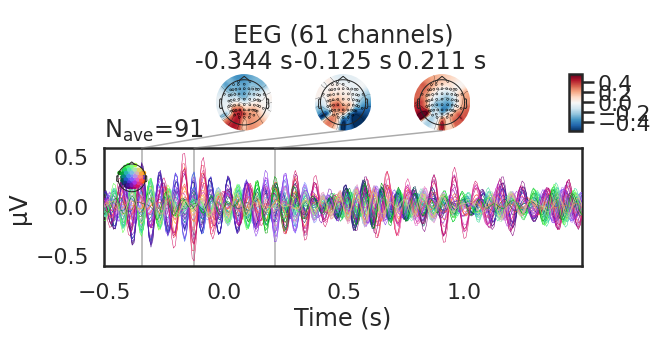

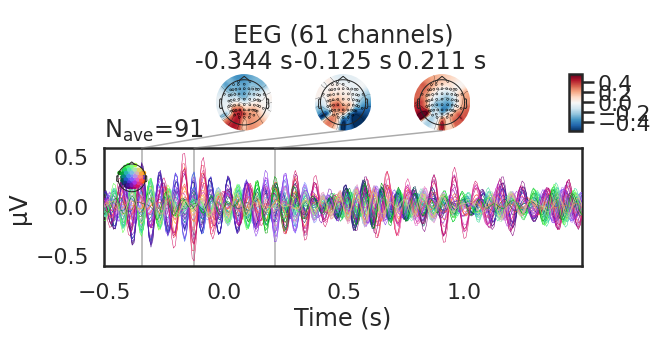

In [16]:
# downsampling
epochs = epochs.resample(128)
# let's see how a spindle look like on average
evoked = epochs.average()
evoked.filter(12,14)
evoked.plot_joint()



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    3.2s


Not setting metadata


[Parallel(n_jobs=2)]: Done  61 out of  61 | elapsed:    5.9s finished


[Text(0, 0.5, 'Frequency (Hz)'),
 Text(0.5, 0, 'Time (sec)'),
 Text(0.5, 1.0, 'Example of spindle averaged of all channels')]

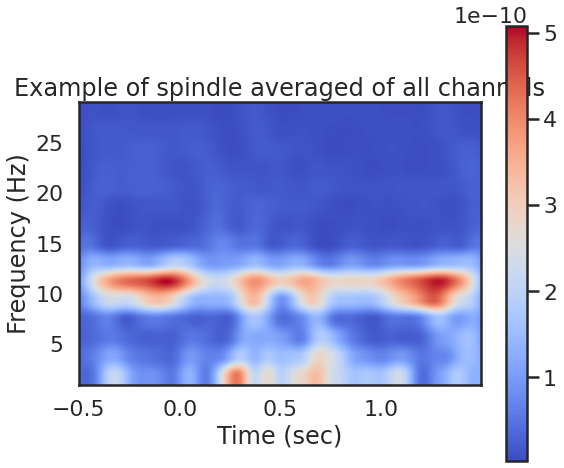

In [17]:
# convert the segmented data to time-freqency format
freqs = np.arange(1.,31,2)
n_cycles = freqs / 2.
power = mne.time_frequency.tfr_morlet(epochs,
                                        freqs = freqs,
                                        n_cycles = n_cycles,
                                        return_itc = False,
                                        average = False,
                                        n_jobs = 2,
                                        )
# visualize one of the spindles (not averaging)
example = power.data[np.random.randint(1,event_array.shape[0])]
fig,ax = plt.subplots(figsize = (9,8))
im = ax.imshow(example.mean(0),
                origin = 'lower',
                aspect = .05,
                cmap = plt.cm.coolwarm,
                extent = [epochs.times.min(),
                            epochs.times.max(),
                            freqs.min(),
                            freqs.max()]
                )
plt.colorbar(im)
ax.set(xlabel = 'Time (sec)',
        ylabel = 'Frequency (Hz)',
        title = 'Example of spindle averaged of all channels')



In [18]:
# k-complex
kcomplex_events = events[events['Annotation'] == 'k-complex']
event_array = np.vstack([kcomplex_events['Onset'].values,
                            [0] * kcomplex_events.shape[0],
                            [1] * kcomplex_events.shape[0]]).T.astype(int)



Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 4 events and 2001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 5.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Filter length: 423 samples (3.305 sec)

Projections have already been applied. Setting proj attribute to True.


<ipython-input-19-e3faa3290721>:16: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  evoked.filter(1,5)


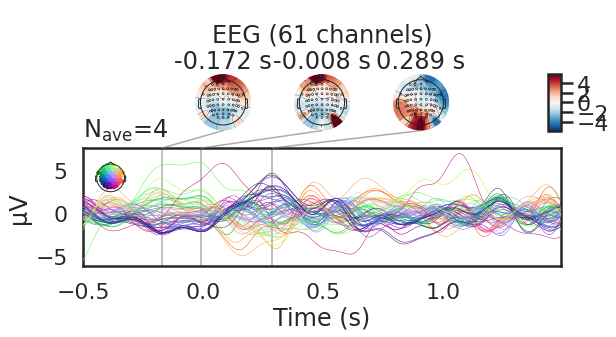

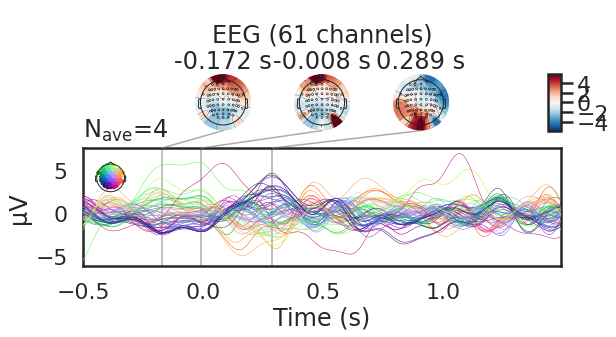

In [19]:
# cut the data in segments
picks = mne.pick_types(raw.info,eeg = True, eog = False, misc = False)
epochs = mne.Epochs(raw,
                    events = event_array,
                    event_id = {'k-complex':1},
                    tmin = -0.5,
                    tmax = 1.5,
                    baseline = (-0.5,-0.2),
                    preload = True,
                    picks = picks,
                    detrend = 1,
                    )
epochs = epochs.resample(128)
# let's see how a spindle look like on average
evoked = epochs.average()
evoked.filter(1,5)
evoked.plot_joint()



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  52 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  61 out of  61 | elapsed:    0.2s finished


Not setting metadata


[Text(0, 0.5, 'Frequency (Hz)'),
 Text(0.5, 0, 'Time (sec)'),
 Text(0.5, 1.0, 'Example of k-complex averaged of all channels')]

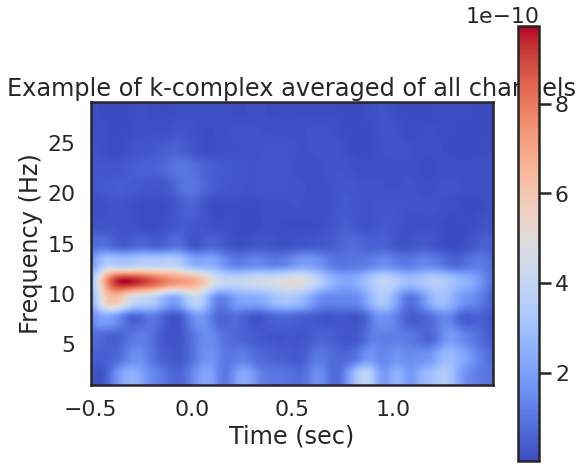

In [20]:
# convert the segmented data to time-freqency format
freqs = np.arange(1.,31,2)
n_cycles = freqs / 2.
power = mne.time_frequency.tfr_morlet(epochs,
                                        freqs = freqs,
                                        n_cycles = n_cycles,
                                        return_itc = False,
                                        average = False,
                                        n_jobs = 2,
                                        )
# visualize one of the spindles (not averaging)
example = power.data[np.random.randint(1,event_array.shape[0])]
fig,ax = plt.subplots(figsize = (9,8))
im = ax.imshow(example.mean(0),
                origin = 'lower',
                aspect = .05,
                cmap = plt.cm.coolwarm,
                extent = [epochs.times.min(),
                            epochs.times.max(),
                            freqs.min(),
                            freqs.max()]
                )
plt.colorbar(im)
ax.set(xlabel = 'Time (sec)',
        ylabel = 'Frequency (Hz)',
        title = 'Example of k-complex averaged of all channels')

# some functions for filter-based threshold method

In [27]:
def download_EEG_annotation(sub,day,EEG_dir,annotation_dir,):
    row     = df[np.logical_and(
                    df['sub'] == sub,
                    df['day'] == day)
                ]

    url_eeg         = row['link'].values[0]
    url_vmrk        = row['link'].values[1]
    url_vhdr        = row['link'].values[2]
    url_annotation  = row['annotation_file_link'].values[0]

    if not os.path.exists(os.path.join(EEG_dir,
                                       row['name'].values[0])):
        for url in [url_eeg,url_vmrk,url_vhdr]:
            download_url(url,
                         os.path.join(EEG_dir,url.split('/')[-1],)
                         )
    else:
        print('EEG data exists')
    if not os.path.exists(os.path.join(annotation_dir,
                              f'suj{sub}_day{day}_annotations.txt')):
        download_url(url_annotation,
                     os.path.join(annotation_dir,
                                  f'suj{sub}_day{day}_annotations.txt'))
    else:
        print('Annotation exists')
    return None

def load_EEG_raw(vhdr_file_name):
    # load the data
    raw = mne.io.read_raw_brainvision(
            vhdr_file_name,
            preload = True)
    # set the EOG channels
    channel_types = {'LOc':'eog','ROc':'eog','Aux1':'misc'}
    raw.set_channel_types(channel_types)

    raw_ref ,_  = mne.set_eeg_reference(raw,
                                        ref_channels     = 'average',
                                        projection       = True,)
    raw_ref.apply_proj() # it might tell you it already has been re-referenced, but do it anyway

    # read standard montage - montage is important for visualization
#    montage = mne.channels.read_montage('standard_1020',ch_names=raw.ch_names);#montage.plot()
    raw.set_montage('standard_1020')
    return raw
def getOverlap(a,b):
    """
    get the number of ms overlapped between 2 time windows
    """
    return max(0,min(a[1],b[1]) - max(a[0],b[0]))
def window_rms(signal,window_size):
    """
    compute the Root-Mean-Square of a signal using moving window convolution
    """
    from scipy import signal as S
    # sqaure of the signal
    segment_squre = np.power(signal,2)
    # construct a Gaussian moving window
    window = S.gaussian(window_size,(window_size/.68)/2)
    # convolution and scale for visualization
    return np.sqrt(np.convolve(segment_squre,window,'same')/len(signal))*1e2
def trimmed_std(a,p=0.05):
    """
    compute standard deviation by excluding outlier data points
    """
    from scipy import stats
    temp = stats.trimboth(a,p/2)
    return np.std(temp)
def stage_check(x):
    import re
    if re.compile('2',re.IGNORECASE).search(x):
        return True
    else:
        return False
def intervalCheck(a,b,tol=0):#a is an array and b is a point
    return a[0]-tol <= b <= a[1]+tol

class Filter_based_and_thresholding:
    """
    Parameters:
        channelList: list, channels that are interested
        moving_window_size:float, in second, length of the moving window for RMS convolution. Empirically, it works better when equal to the sampleing rate of the signal
        moving_window_step:float, in second, size of step moving the window for segmenting the signal
        l_bound:float, in seconds, low boundary for duration of a spindle instance
        h_bound:flaot, in seconds, high boundary for duration of a spindle instance
        syn_channels:int, criteria for selecting spindles: at least # of channels have spindle instance and also in the mean channel
        tol:int, in number of samples, tolerance for determing spindles (criteria in time samples)
        front:float, in seconds, First few seconds of recordings that we are not interested because there might be artifacts,
                or it is confirmed subjects could not fall asleep within such a short period
        back:float, in seconds, last few seconds of recordings that we are not interested due to the recording procedures
        validation_windowsize:float, in seconds, the windowsize to segment the data.
        l_freq_desired:int, in Hz, high pass frequency (lower bound) of the desired events
        h_freq_desired:int, in Hz, low pass frequency (high bound) of the desired events
        l_freq:int, in Hz, high pass frequency
        h_freq:int, in Hz, low pass frequency
        lower_threshold:float, highpass threshold for spindle detection:
            decision making = trimmed_mean + lower_T * trimmed_std
        higher_threshold:float, lowpass threshold for spindle detection:
            decision making = trimmed_mean + higher_T * trimmed_std
        before_onset:float, in seconds, time to consider before an onset of an event
        after_onset:float, in seconds, time to consider after an onset of an event
    """
    def __init__(self,
                 channelList            = None,
                 moving_window_size     = 1.,
                 moving_window_step     = 0.2,
                 syn_channels           = 3,
                 l_bound                = 0.5,
                 h_bound                = 2,
                 tol                    = 0.02,
                 front                  = 5 * 60,
                 back                   = 5 * 60,
                 validation_windowsize  = 1,
                 l_freq_desired         = 11,
                 h_freq_desired         = 16,
                 l_freq                 = 1,
                 h_freq                 = 30,
                 lower_threshold        = .7,
                 higher_threshold       = 3.5,
                 before_onset           = .25,
                 after_onset            = 1.250,
                 ):
        if channelList is None:
            self.channelList            = ['F3','F4','C3','C4','O1','O2']
        else:
            self.channelList            = channelList
        self.moving_window_size         = moving_window_size
        self.moving_window_step         = moving_window_step
        self.syn_channels               = syn_channels
        self.l_bound                    = l_bound
        self.h_bound                    = h_bound
        self.front                      = front
        self.back                       = back
        self.validation_windowsize      = validation_windowsize
        self.l_freq_desired             = l_freq_desired
        self.h_freq_desired             = h_freq_desired
        self.l_freq                     = l_freq
        self.h_freq                     = h_freq
        self.tol                        = tol
        self.lower_threshold            = lower_threshold
        self.higher_threshold           = higher_threshold
        self.before_onset               = before_onset
        self.after_onset                = after_onset


    def get_raw(self,raw_file_name):
        """
        load the EEG raw signals
        """
        raw         = load_EEG_raw(raw_file_name)
        # filter the data if filter band is not None
        if (self.l_freq is not None) or (self.h_freq is not None):
            raw.filter(self.l_freq,self.h_freq)
        self.raw    = raw
        sfreq       = raw.info['sfreq']
        self.sfreq  = sfreq

    def get_annotation(self,annotation_file_name):
        """
        load the annotation file
        """
        # create time segments for cutting overlapping windows
        df_events               = pd.read_csv(annotation_file_name)
        self.df_events          = df_events
        # since we don't want to have too many "normal" data (labeled 0),
        # we cut off the last part of EEG when no particular events
        spindle_events          = df_events[df_events['Annotation'] == 'spindle']
        kcomplex_events         = df_events[df_events['Annotation'] == 'k-complex']
        stage_2_sleep_events    = df_events[df_events['Annotation'].apply(lambda x: np.logical_or(
                                                'Markon' in x, 'Markoff' in x))]
        self.event_dictionary   = {'spindle':spindle_events,
                                   'kcomplex':kcomplex_events,
                                   'stage_2_sleep':stage_2_sleep_events,
                                   }
        # we only look at the data from when the first 2nd stage sleep started
        if len(stage_2_sleep_events) > 1:
            print('stage 2 sleep annotations are provided')
            self.tmin           = np.min(stage_2_sleep_events['Onset'].values)
        else:
            self.tmin           = 0
        # and we stop looking at the data when the last spindle, kcomplex, or 2nd stage stops,
        # whichever one happens the latest
        self.tmax                = np.max([spindle_events['Onset'].values.max(),
                                           kcomplex_events['Onset'].values.max() + 1,
                                           stage_2_sleep_events['Onset'].values.max() + 1,
                                           ])

    def make_events_windows(self,
                            time_steps  = None,# in seconds
                            window_size = None,# in seconds
                            ):
        """
        prepare time windows for segementing the EEG continued signal to fixed length epochs
        """
        if time_steps is None:
            time_steps      = self.moving_window_step
        else:
            time_steps      = time_steps
        if window_size is None:
            window_size     = self.validation_windowsize
        else:
            window_size     = window_size
        self.window_size    = window_size
        
        overlapping         = window_size - time_steps
        events              = mne.make_fixed_length_events(
                                            self.raw,
                                            id          = 1,
                                            start       = self.tmin,
                                            stop        = self.tmax,
                                            duration    = window_size,
                                            overlap     = overlapping,
                                                          )
        # now in milliseconds
        onsets              = events[:,0]
        offsets             = onsets + window_size * self.sfreq
        self.windows        = np.vstack([onsets,offsets]).T.astype(int)

    def label_segments(self,
                       event_time_stamps,
                       event_durations  = None,
                       event_type       = 'spindle',
                       return_proba     = False,
                       ):
        """
        label the segmented time windows depends on whether the windows overlap the event time stamps
        """
        labels              = []
        proba               = []
        if event_durations is None:
            # let's define all event lasted for 1.5 seconds and the annotated time stamp was put on the .25 second location
            intervals       = [[item - self.before_onset * self.sfreq,
                                item + self.after_onset * self.sfreq 
                                ] for item in event_time_stamps]
        else:
            # if the event time stamps were computed by other algorithms, we have different lendth of durations
            intervals       = [[(item - duration/2.) * self.sfreq,
                                (item + duration/2.) * self.sfreq
                                ] for item,duration in zip(event_time_stamps,event_durations)]
        # if the segmented window overlap any spindle window, it is defined as a spindle segment
        # but, we want to define the "overlap" better, so I also add a term "tolerate"
        # only if the overlapping is more than some minimum requirement -- tolerate -- we can say it is a spindle
        tol                 = self.tol * self.sfreq # in milliseconds
        for window in tqdm(self.windows):
            if np.sum([getOverlap(window,item) for item in intervals]) > tol:
                labels.append(1)
                proba.append((np.sum([getOverlap(window,item) for item in intervals])) / (window[1] - window[0]))
            else:
                labels.append(0)
                proba.append(0.)
        print(Counter(labels))
        self.event_id       = {f'{event_type}':1,f'not {event_type}':0}
        onsets              = self.windows[:,0]
        events              = np.vstack([onsets,
                                         np.zeros(onsets.shape),
                                         np.array(labels)]).T.astype(int)
        if return_proba:
            return events, proba
        else:
            return events

    def get_epochs(self,events,resample = None):
        """
        cut the continue EEG signals to fixed length epochs
        """
        raw                 = self.raw.copy()
        raw.filter(self.l_freq_desired,
                           self.h_freq_desired)
        picks               = mne.pick_types(raw.info,
                                             eeg    = True,
                                             eog    = False,
                                             misc   = False)
        self.epochs         = mne.Epochs(raw,
                                         events     = events,
                                         event_id   = self.event_id,
                                         tmin       = 0,
                                         tmax       = self.window_size,
                                         baseline   = (0,None), # arguebly
                                         preload    = True,
                                         picks      = picks,
                                         detrend    = 1,
                                         )
        if resample is not None:
            self.epochs = self.epochs.resample(resample)
    def get_powers(self, resample = None, n_jobs = 2):
        """
        compute time-frequency spectral power based on the epochs
        """
        if resample is not None:
            epochs = self.epochs.resample(resample)
        else:
            epochs = self.epochs.copy()
        # convert the segmented data to time-freqency format
        freqs               = np.arange(self.l_freq,self.h_freq + 2,2)
        n_cycles            = freqs / 2.
        power               = mne.time_frequency.tfr_morlet(epochs,
                                                            freqs       = freqs,
                                                            n_cycles    = n_cycles,
                                                            return_itc  = False,
                                                            average     = False,
                                                            n_jobs      = n_jobs,
                                                            )

        self.psds           = power
        self.freq           = freqs
    def find_onset_duration(self,
                            lower_threshold     = None,
                            higher_threshold    = None,
                            ):
        """
        Pattern matching algorithm: fliter-based thresholding
        """
        from scipy.stats import trim_mean,hmean
        if lower_threshold is None:
            if self.lower_threshold is None:
                lower_threshold = .9
            else:
                lower_threshold = self.lower_threshold
        if higher_threshold is None:
            if self.higher_threshold is None:
                higher_threshold = 3.5
            else:
                higher_threshold = self.higher_threshold
        # if the original bandpass filter is not the same as the desired filter band, we filter the data again
        if (self.raw.info['highpass'] != self.l_freq_desired) or (self.raw.info['lowpass'] != self.h_freq_desired):
            raw = self.raw.copy().filter(self.l_freq_desired,self.h_freq_desired)
        else:
            raw = self.raw.copy()
        raw.pick_channels(self.channelList)
        
        # key parameters
        self.lower_threshold    = lower_threshold
        self.higher_threshold   = higher_threshold
        
        # parts of signals to ignore
        front                   = self.front * self.sfreq
        back                    = (raw.last_samp - self.back) * self.sfreq
        # channel list
        channelList             = self.channelList
        # RMS convolution window size
        moving_window_size      = self.moving_window_size * self.sfreq
        # time constraint
        l_bound                 = self.l_bound
        h_bound                 = self.h_bound
        # tolerate
        tol                     = self.tol * self.raw.info['sfreq']
        syn_channels            = self.syn_channels
        
        # pre-allocation
        time                    = raw.times
        RMS                     = np.zeros((len(channelList),raw.times.shape[0]))
        peak_time,mph,mpl       = {},{},{}

        # for each channel, we compute the Root-Mean-Square of the signal
        for ii,name in enumerate(self.channelList):
            segment,_           = raw[ii,:]
            RMS[ii,:]           = window_rms(segment[0,:],moving_window_size)
            # range of power by the mean without noise data
            mph[name]           = trim_mean(RMS[ii,int(front):int(back)],0.05) + lower_threshold * trimmed_std(RMS[ii,int(front):int(back)],0.05)
            mpl[name]           = trim_mean(RMS[ii,int(front):int(back)],0.05) + higher_threshold * trimmed_std(RMS[ii,int(front):int(back)],0.05)
            pass_               = RMS[ii,:] > mph[name]#should be greater than then mean not the threshold to compute duration
            # find the cut points between the RMS and the ranges
            up,                 = np.where(np.diff(pass_.astype(int))>0)
            down,               = np.where(np.diff(pass_.astype(int))<0)
            # cut point check
            if down[0] < up[0]:
                down            = down[1:]
            if (up.shape > down.shape) or (up.shape < down.shape):
                size            = np.min([up.shape,down.shape])
                up              = up[:size]
                down            = down[:size]
            
            peak_time[name]     = []
            pairs               = np.vstack((up,down)).T
            for pair in pairs:
                # if the duration of this detected segement 
                if l_bound < (time[pair[1]] - time[pair[0]]) < h_bound:
                    SegmentForPeakSearching = RMS[ii,pair[0]:pair[1]]
                    if np.max(SegmentForPeakSearching) < mpl[name]:
                        temp_temp_time      = time[pair[0]:pair[1]]
                        ints_temp           = np.argmax(SegmentForPeakSearching)
                        peak_time[name].append(temp_temp_time[ints_temp])
        # do the same for the average of the channels
        peak_time['mean'],peak_at,duration  = [],[],[]
        RMS_mean                            = hmean(RMS)
        mph['mean']                         = trim_mean(RMS_mean[int(front):int(back)],0.05) + lower_threshold * trimmed_std(RMS_mean,0.05)
        mpl['mean']                         = trim_mean(RMS_mean[int(front):int(back)],0.05) + higher_threshold * trimmed_std(RMS_mean,0.05)
        pass_                               = RMS_mean > mph['mean']
        up,                                 = np.where(np.diff(pass_.astype(int))>0)
        down,                               = np.where(np.diff(pass_.astype(int))<0)
        # cut point check
        if down[0] < up[0]:
            down                = down[1:]
        if (up.shape > down.shape) or (up.shape < down.shape):
            size                = np.min([up.shape,down.shape])
            up                  = up[:size]
            down                = down[:size]
        pairs                   = np.vstack((up,down)).T
        for pair in pairs:
            if l_bound < (time[pair[1]] - time[pair[0]]) < h_bound:
                SegmentForPeakSearching     = RMS_mean[pair[0]:pair[1]]
                if np.max(SegmentForPeakSearching)< mpl['mean']:
                    temp_time               = time[pair[0]:pair[1]]
                    ints_temp               = np.argmax(SegmentForPeakSearching)
                    peak_time['mean'].append(temp_time[ints_temp])
                    peak_at.append(SegmentForPeakSearching[ints_temp])
                    duration_temp           = time[pair[1]] - time[pair[0]]
                    duration.append(duration_temp)
        # check the time windows across the channels, see if they agree
        time_find,mean_peak_power,Duration  = [],[],[]
        for item,PEAK,duration_time in zip(peak_time['mean'],peak_at,duration):
            temp_timePoint                  = []
            for ii, names in enumerate(channelList):
                try:
                    temp_timePoint.append(min(enumerate(peak_time[names]), key=lambda x: abs(x[1]-item))[1])
                except:
                    temp_timePoint.append(item)
            try:
                if np.sum((abs(np.array(temp_timePoint) - item)<tol).astype(int))>=syn_channels:
                    time_find.append(float(item))
                    mean_peak_power.append(PEAK)
                    Duration.append(duration_time)
            except Exception as e:
                print(e)
        self.time_find          = time_find
        self.mean_peak_power    = mean_peak_power
        self.Duration           = Duration

    def sleep_stage_check(self):
        """
        If stage 2 sleep annotations were provided, we use these time windows to 
        exclude some of the events we found
        """
        try:
            annotations         = self.event_dictionary['stage_2_sleep']
        except:
            annotations         = None
            print('stage 2 missing')
        tol                     = self.tol * self.sfreq
        time_find               = self.time_find
        mean_peak_power         = self.mean_peak_power
        Duration                = self.Duration
        front                   = self.front
        last                    = self.raw.last_samp - self.back
        if annotations is not None:
            temp_time_find,temp_mean_peak_power,temp_duration = [],[],[]
            # seperate out stage 2
            On                  = annotations[annotations['Annotation'].apply(lambda x:'Markon:2' in x)]
            Off                 = annotations[annotations['Annotation'].apply(lambda x:'Markoff:2' in x)]
            if On.Onset.values[0] > Off.Onset.values[0]:
                On              = np.concatenate([[Off.Onset.values[0] - 30],On.Onset.values])
                Off             = Off.Onset.values
            else:
                On              = On.Onset.values
                Off             = Off.Onset.values
            stage_on_off        = np.vstack([On, Off]).T
            for single_time_find, single_mean_peak_power, single_duration in zip(time_find,mean_peak_power,Duration):
                for on_time,off_time in stage_on_off:
                    if intervalCheck([on_time,off_time],single_time_find,tol=tol):
                        temp_time_find.append(      single_time_find)
                        temp_mean_peak_power.append(single_mean_peak_power)
                        temp_duration.append(       single_duration)
            time_find           = temp_time_find
            mean_peak_power     = temp_mean_peak_power
            Duration            = temp_duration
            self.time_find      = temp_time_find
            self.mean_peak_power= temp_mean_peak_power
            self.Duration       = temp_duration
        
        result = pd.DataFrame({'Onset':time_find,'Duration':Duration,'Annotation':['spindle']*len(Duration)})
        result = result[(result['Onset'] > front) & (result['Onset'] < last)]
        self.auto_scores = result

    def fit(self,
            labels,
            resample = None,
            n_jobs = 1):
        from sklearn.linear_model    import LogisticRegressionCV
        from sklearn.model_selection import cross_val_predict,StratifiedKFold
        from sklearn.pipeline        import Pipeline
        from sklearn.preprocessing   import StandardScaler
        from mne.decoding            import Vectorizer
        
        epochs              = self.epochs
        if resample is not None:
            epochs          = epochs.resample(resample)
        epochs.pick_channels(self.channelList)
        decision_features   = epochs.get_data()
        print(f'feature shape = {decision_features.shape}')
        cv                  = StratifiedKFold(n_splits        = 5,
                                              shuffle         = True,
                                              random_state    = 12345)
        clf                 = LogisticRegressionCV(
                                    Cs              = np.logspace(-4,6,11),
                                    cv              = cv,
                                    tol             = 1e-2,
                                    max_iter        = int(1e4),
                                    scoring         = 'roc_auc',
                                    class_weight    = 'balanced',
                                    n_jobs          = n_jobs,
                                    )
        clf                 = Pipeline([('vectorizer',Vectorizer()),
                                        ('scaler',StandardScaler()),
                                        ('estimator',clf)])
        
        auto_proba      = cross_val_predict(clf,
                                            decision_features,
                                            labels,
                                            cv      = cv,
                                            method  = 'predict_proba',
                                            n_jobs  = 1,
                                            verbose = 1,
                                            )
        auto_proba      = auto_proba[:,-1]
        
        self.classification_labels  = labels
        self.auto_proba             = auto_proba

In [22]:
download_EEG_annotation(sub,day,EEG_dir,annotation_dir,)

EEG data exists
Annotation exists


In [37]:
FBT = Filter_based_and_thresholding(moving_window_step = .25,
                                    moving_window_size = 1.5,)

In [38]:
FBT.get_raw(glob(os.path.join(EEG_dir, f'suj{sub}_*nap_day{day}.vhdr'))[0])
FBT.get_annotation(os.path.join(annotation_dir,f'suj{sub}_day{day}_annotations.txt'))
FBT.make_events_windows()#time_steps = 3000,window_size = 3000)

Extracting parameters from Get_Sleep_data/EEG/suj29_l5nap_day1.vhdr...
Setting channel info structure...
Reading 0 ... 1804949  =      0.000 ...  1804.949 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3

In [39]:
events = FBT.event_dictionary['spindle']
event_time_stamps = np.array(events['Onset'].values * FBT.raw.info['sfreq'],dtype = 'int')
y_true = FBT.label_segments(event_time_stamps)

100%|██████████| 7082/7082 [00:02<00:00, 3058.19it/s]

Counter({0: 6162, 1: 920})


In [40]:
events

,Onset,Duration,Annotation
19,286.576393,NaN,spindle
22,309.657967,NaN,spindle
29,410.956500,NaN,spindle
38,539.745794,NaN,spindle
41,547.636397,NaN,spindle
...,...,...,...
207,1689.952959,NaN,spindle
208,1700.663859,NaN,spindle
211,1731.640163,NaN,spindle
214,1741.753907,NaN,spindle


In [41]:
y_true

array([[    294,       0,       0],
       [    544,       0,       0],
       [    794,       0,       0],
       ...,
       [1770044,       0,       0],
       [1770294,       0,       0],
       [1770544,       0,       0]])

In [42]:
FBT.find_onset_duration(lower_threshold = .9, higher_threshold = 3.)
y_pred,y_prob = FBT.label_segments(np.array(FBT.time_find),np.array(FBT.Duration),return_proba = True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 11 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 11.00
- Lower transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 9.62 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 1201 samples (1.201 sec)



100%|██████████| 7082/7082 [00:02<00:00, 2396.01it/s]

Counter({0: 6035, 1: 1047})


In [43]:
print(metrics.roc_auc_score(y_true[:,-1],y_pred[:,-1]))
print(metrics.roc_auc_score(y_true[:,-1],y_prob))

0.7186095000211675
0.7239510569690811


In [44]:
events           = np.vstack([FBT.windows[:,0],
                                np.zeros(y_true.shape[0]),
                                y_true[:,-1]
                                ]).T.astype(int)
print('stage 2 sleep constraint')
FBT.sleep_stage_check()

stage 2 sleep constraint


In [45]:
y_pred,y_prob = FBT.label_segments(np.array(FBT.time_find),np.array(FBT.Duration),return_proba = True)
print(metrics.roc_auc_score(y_true[:,-1],y_pred[:,-1]))
print(metrics.roc_auc_score(y_true[:,-1],y_prob))

100%|██████████| 7082/7082 [00:03<00:00, 1820.89it/s]

Counter({0: 6202, 1: 880})
0.70967394832282
0.7138190945909713
